In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten

# 딥러닝 layer 관련
from tensorflow.keras.layers import Dense, Concatenate, Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [13]:
# DataFrame 형태로 데이터를 읽어온다.
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

# 유저-영화 평점 데이터 "u.data"
ratings = pd.read_csv('./u.data', 
                     names=r_cols,
                      sep='\t',
                      encoding='latin-1'
                     )
print(ratings.shape)
ratings.head()

(100000, 4)


,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [14]:
# 학습,테스트 구분하기
ratings_train, ratings_test = train_test_split(ratings,
                                              test_size=0.2,
                                              shuffle=True,
                                              random_state=2022)

In [15]:
# RMSE 함수 (keras에는 RMSE 메소드 없어서 만들어줘야 함)
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [16]:
# 잠재 요인의 수 
K=200

# 전체 평점 평균
mu = ratings_train.rating.mean()

# 사용자id, 영화id의 최대값을 구한다.
# bias term의 크기 1을 고려하여 +1을 해준다.
M = ratings.user_id.max() + 1
N = ratings.movie_id.max() + 1

In [17]:
print('사용자 개수 max값:', M)
print('아이템 개수 max값:', N)

사용자 개수 max값: 944
아이템 개수 max값: 1683


# 케라스 모델 생성

In [19]:
user = Input(shape=(1, ))
item = Input(shape=(1, ))

# 행렬 P,Q 임베딩
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)

# 사용자, 아이템 평가 경향도 임베딩
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)

In [22]:
# concatenate를 위해서는 1차원으로 Flatten해야 한다.
P_embedding = Flatten()(P_embedding)
Q_embedding = Flatten()(Q_embedding)

user_bias = Flatten()(user_bias)
item_bias = Flatten()(item_bias)

R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])

In [23]:
# layer 쌓기

# 노드가 2048개인 layer 생성.
# 활성화 함수는 'linear'
R = Dense(2048)(R)
R = Activation('linear')(R)

# 노드가 256개인 layer 추가
R = Dense(256)(R)
R = Activation('linear')(R)

# 노드가 1개인 dense layer(출력층) 한 개 추가
R = Dense(1)(R)

In [24]:
model = Model(inputs=[user, item], outputs=R)

model.compile(
    loss = RMSE,
    optimizer = SGD(),  # adam, adamax
    metrics= [RMSE]
)

model.summary()
# 사용자 수가 944, 잠재요인 수가 200 -> 944x200 = 188800
# concatenate를 위해 flatten

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 200)       188800      ['input_5[0][0]']                
                                                                                                  
 embedding_9 (Embedding)        (None, 1, 200)       336600      ['input_6[0][0]']                
                                                                                            

In [25]:
# 학습 데이터 정의
train_user_ids = ratings_train.user_id.values, 
train_movie_ids = ratings_train.movie_id.values
train_ratings = ratings_train.rating.values

# 테스트 데이터 정의
test_user_ids = ratings_test.user_id.values, 
test_movie_ids = ratings_test.movie_id.values
test_ratings = ratings_test.rating.values

In [26]:
result = model.fit(
    x = [train_user_ids, train_movie_ids], 
    y = train_ratings - mu,
    epochs = 65,
    batch_size = 512,
    validation_data = (
        [test_user_ids, test_movie_ids], 
        test_ratings - mu
    )
)

Epoch 1/65
157/157 [==============================] - 5s 31ms/step - loss: 5.3984 - RMSE: 1.1254 - val_loss: 5.2611 - val_RMSE: 1.1195
Epoch 2/65
157/157 [==============================] - 4s 28ms/step - loss: 5.1366 - RMSE: 1.1236 - val_loss: 5.0075 - val_RMSE: 1.1177
Epoch 3/65
157/157 [==============================] - 4s 28ms/step - loss: 4.8909 - RMSE: 1.1223 - val_loss: 4.7696 - val_RMSE: 1.1164
Epoch 4/65
157/157 [==============================] - 5s 30ms/step - loss: 4.6601 - RMSE: 1.1214 - val_loss: 4.5463 - val_RMSE: 1.1153
Epoch 5/65
157/157 [==============================] - 5s 29ms/step - loss: 4.4431 - RMSE: 1.1189 - val_loss: 4.3358 - val_RMSE: 1.1132
Epoch 6/65
157/157 [==============================] - 5s 30ms/step - loss: 4.2393 - RMSE: 1.1169 - val_loss: 4.1383 - val_RMSE: 1.1115
Epoch 7/65
157/157 [==============================] - 5s 30ms/step - loss: 4.0478 - RMSE: 1.1154 - val_loss: 3.9528 - val_RMSE: 1.1098
Epoch 8/65
157/157 [==============================] - 5

157/157 [==============================] - 6s 36ms/step - loss: 1.0356 - RMSE: 0.9207 - val_loss: 1.0516 - val_RMSE: 0.9421
Epoch 62/65
157/157 [==============================] - 6s 35ms/step - loss: 1.0290 - RMSE: 0.9205 - val_loss: 1.0454 - val_RMSE: 0.9419
Epoch 63/65
157/157 [==============================] - 6s 36ms/step - loss: 1.0230 - RMSE: 0.9203 - val_loss: 1.0449 - val_RMSE: 0.9468
Epoch 64/65
157/157 [==============================] - 6s 37ms/step - loss: 1.0180 - RMSE: 0.9209 - val_loss: 1.0358 - val_RMSE: 0.9431
Epoch 65/65
157/157 [==============================] - 5s 35ms/step - loss: 1.0126 - RMSE: 0.9207 - val_loss: 1.0309 - val_RMSE: 0.9433


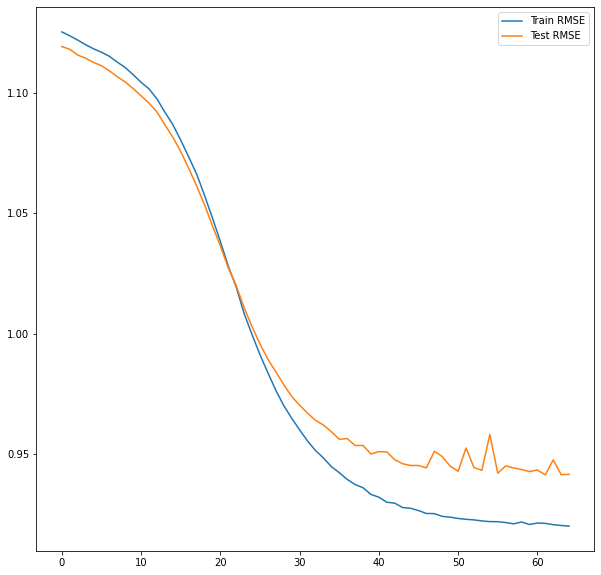

In [11]:
# 학습 과정 시각화
plt.figure(figsize=(10, 10))
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.legend()
plt.show()